# <center> House Prices -- Advance Regression Technique </center>
----

data source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=test.csv

**Aim** : To build a predictive model to predict housing price



In [1]:
import inflection as infl
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from plotly.subplots import make_subplots
from scipy.stats import linregress, uniform, randint 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression, r_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor


In [2]:
##### helper functions

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])


def describe_dataframe(dataframe: pd.DataFrame):
    
    pd.options.display.float_format = '{:,.3f}'.format
    
    return dataframe.select_dtypes([int, float]).describe()


In [3]:
##### load house price data and rename column to snake case
house_df = pd.read_csv("house_price_train.csv")
house_df.columns = [infl.underscore(val) for val in house_df.columns]

house_df


,id,ms_sub_class,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,sale_price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
##### introduce new columns
house_df["age_sold"] = house_df["yr_sold"] - house_df["year_built"]

# house_df["age_sold"]

----
# <center> Data Clean Up </center>
---

Determine the amount of rows with NaN values. The following features are removed since the amount missing values are >10%. 

ID was also removed since it does not contribute to the prediction.

| Feature | Description |
| --- | --- | 
| pool_qc | pool quality | 
| misc_feature | Miscellaneous features not covered in other categories | 
| alley |  Type of alley access to property | 
| fence |  Fence quality  | 
| mas_vnr_type |  Masonry veneer type -- Brick, stone, etc. | 
| fireplace_qu |  Fireplace quality | 
| lot_frontage |  Linear feet of street connected to property| 

In [5]:
col_names = [val for val in house_df.columns]
nan_count = [len(house_df.loc[house_df[val].isna(), val]) for val in house_df.columns]

nan_count_df = pd.DataFrame(list(zip(col_names, nan_count)), columns=["column", "nan_count"])
nan_count_df["nan_percent"] = nan_count_df["nan_count"]/len(house_df)*100

##### Display the column with NaN; sort according to the amount of NaN in columns
nan_count_df[nan_count_df["nan_percent"]>10].sort_values(["nan_count"], ascending=False)

,column,nan_count,nan_percent
72,pool_qc,1453,99.520548
74,misc_feature,1406,96.301370
6,alley,1369,93.767123
73,fence,1179,80.753425
25,mas_vnr_type,872,59.726027
57,fireplace_qu,690,47.260274
3,lot_frontage,259,17.739726


In [6]:
##### remove features with more than 10% NaN row

nan_removal = nan_count_df.loc[nan_count_df["nan_percent"]>10, "column"].to_list()
nan_removal = nan_removal + ["id"]

cleaned_house_df = house_df.drop(columns=nan_removal)

cleaned_house_df.head(5)

,ms_sub_class,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,...,3_ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,sale_condition,sale_price,age_sold
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,0,0,2,2006,WD,Abnorml,140000,91
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000,8


---
# <center> Exploratory Data Analysis </center>
---



In [7]:
house_df_summary = dataframe_summary(cleaned_house_df, 10)
house_df_summary.sort_values(["percent_complete", "data_type"], ascending=[False, True])

,column_name,unique_count,uniqueness,nan_count,nan_percent,percent_complete,data_type,unique_entries
0,ms_sub_class,15,1.0274,0.0000,0.0000,100.0000,int64,>10 entries
2,lot_area,1073,73.4932,0.0000,0.0000,100.0000,int64,>10 entries
14,overall_qual,10,0.6849,0.0000,0.0000,100.0000,int64,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]"
15,overall_cond,9,0.6164,0.0000,0.0000,100.0000,int64,"[5, 8, 6, 7, 4, 2, 3, 9, 1]"
16,year_built,112,7.6712,0.0000,0.0000,100.0000,int64,>10 entries
...,...,...,...,...,...,...,...,...
53,garage_type,7,0.4795,81.0000,5.5479,94.4521,object,"[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen..."
55,garage_finish,4,0.2740,81.0000,5.5479,94.4521,object,"[RFn, Unf, Fin, nan]"
58,garage_qual,6,0.4110,81.0000,5.5479,94.4521,object,"[TA, Fa, Gd, nan, Ex, Po]"
59,garage_cond,6,0.4110,81.0000,5.5479,94.4521,object,"[TA, Fa, nan, Gd, Po, Ex]"


## Sale Price with Respect to Neighborhood

In [8]:
house_neighborhood = house_df[["neighborhood", "sale_price", "gr_liv_area", "age_sold"]].groupby(["neighborhood"]).agg(["mean", "median", "std"]).reset_index()
house_neighborhood = house_neighborhood.sort_values(("sale_price", "mean"), ascending=False)
house_neighborhood["mean_scaled"] = house_neighborhood["sale_price"]["mean"]/house_neighborhood["gr_liv_area"]["mean"]
house_neighborhood["median_scaled"] = house_neighborhood["sale_price"]["median"]/house_neighborhood["gr_liv_area"]["median"]



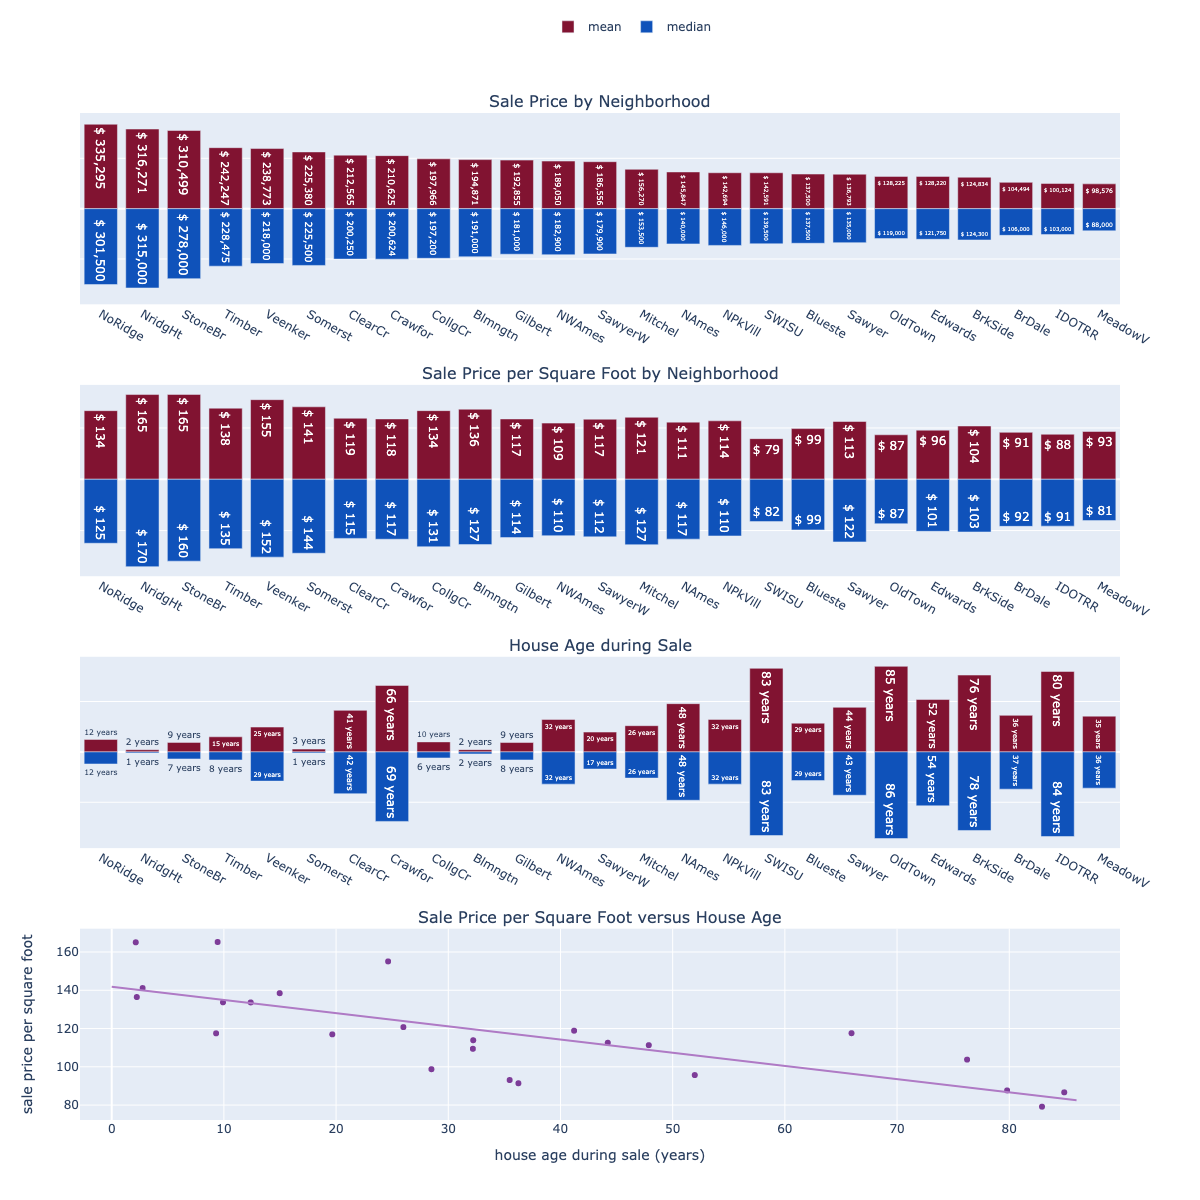

In [10]:
linregress_result = linregress(x=house_neighborhood[("age_sold", "mean")], y=house_neighborhood["mean_scaled"])
linregress_result

dummy_x = [val for val in range(87)]
dummy_y = [linregress_result[0]*val + linregress_result[1] for val in dummy_x]

fig_eda_1 = make_subplots(rows=4, cols=1, 
                          subplot_titles=["Sale Price by Neighborhood", "Sale Price per Square Foot by Neighborhood",
                                          "House Age during Sale", "Sale Price per Square Foot versus House Age"],
                            vertical_spacing=0.08)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["sale_price"]["mean"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["sale_price"]["mean"], texttemplate='$ %{text:,.0f}', marker_color="#811331",
                        showlegend=True, legendgroup="mean", name="mean"), 
                 row=1, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["sale_price"]["median"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["sale_price"]["median"], texttemplate='$ %{text:,.0f}', 
                        marker_color="#0F52BA",
                        showlegend=True, legendgroup="median", name="median"), 
                 row=1, col=1)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["mean_scaled"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["mean_scaled"], texttemplate='$ %{text:,.0f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=2, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["median_scaled"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["median_scaled"], texttemplate='$ %{text:,.0f}', 
                        marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=2, col=1)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["age_sold"]["mean"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["age_sold"]["mean"], texttemplate='%{text:,.0f} years', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=3, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["age_sold"]["median"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["age_sold"]["median"], texttemplate='%{text:,.0f} years', 
                        marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=3, col=1)

fig_eda_1.add_trace( go.Scatter(x=house_neighborhood[("age_sold", "mean")], y=house_neighborhood["mean_scaled"], 
                                mode="markers", showlegend=False, marker=dict(color="#7D3C98")),
                    row=4, col=1)

fig_eda_1.add_trace( go.Scatter(x=dummy_x, y=dummy_y, mode="lines", showlegend=False, marker=dict(color="#AF7AC5")),
                    row=4, col=1)


fig_eda_1.update_yaxes(showticklabels=False)

fig_eda_1.update_xaxes(title_text="house age during sale (years)", row=4)
fig_eda_1.update_yaxes(title_text="sale price per square foot", showticklabels=True, row=4)

fig_eda_1.update_layout(height=1200, width = 1200, barmode="overlay", yaxis1=dict(range=[-380000, 380000]),
                        legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.45, orientation="h"))

fig_eda_1.show(renderer="png")

From the first bar plot, it can be seen that North Ridge (NoRidge) area has the most expensive house on average while Meadow Village (MeadowV) area has the cheapest house. However, price per square feet gives a different perspective. From the second bar plot, it can be see that North Ridge Heights (NridgHt) has the highest price per square feet and the lowest price per square feet is South & West of Iowa State University (SWISU). These descrepancy can be contributed by other factors such as the age of the house at point of sale.

The third bar plot shows the average and median house age during sale. It can be seen that areas with old houses such as SWISU and Old Town (OldTown) tend to have cheaper per square feet compared to areas with new houses such as NridgHt. In order to view the effect of house age on price per square foot, a plot of sale price per square foot as a function of house age was plotted, and this was shown as the final plot above. From this plot, it can be seen that the house price per square foot decreases as the house gets older.

## Sale Price Fluctuation

In [11]:
price_temporal = house_df[["yr_sold", "mo_sold", "gr_liv_area", "sale_price"]]
price_temporal["sale_date_str"] = ["{0}-{1}-01".format(price_temporal.loc[val, "yr_sold"], price_temporal.loc[val, "mo_sold"]) for val in range(len(price_temporal))]
price_temporal["date_sold"] = pd.to_datetime(price_temporal["sale_date_str"])
price_temporal["price_per_sf"] = price_temporal["sale_price"]/price_temporal["gr_liv_area"]


price_temporal_ave = price_temporal.groupby("date_sold").mean(numeric_only=True).reset_index()
price_temporal_med = price_temporal.groupby("date_sold").median(numeric_only=True).reset_index()



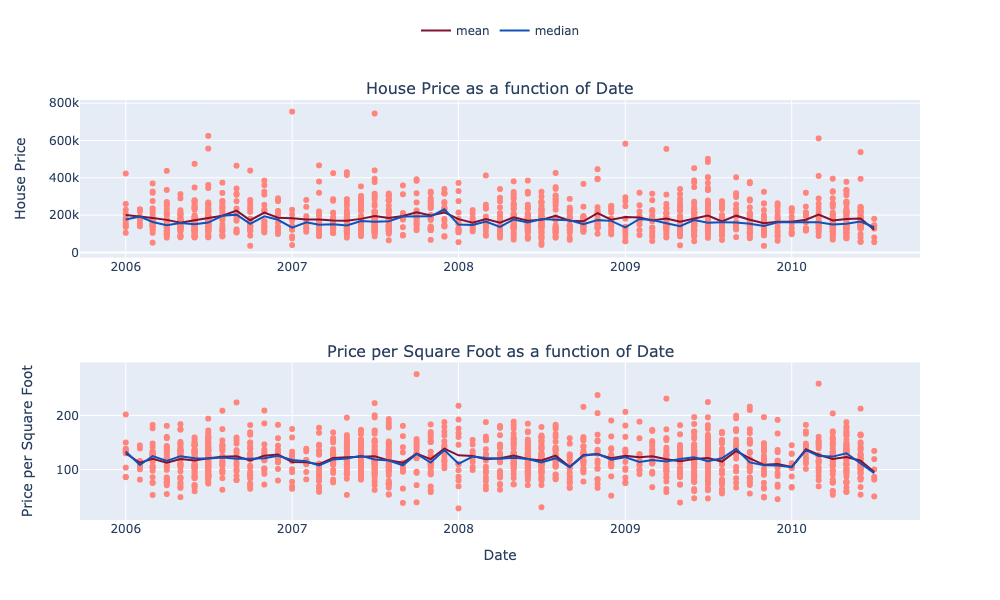

In [13]:
fig_eda_2 = make_subplots(rows=2, cols=1, 
                          subplot_titles=["House Price as a function of Date",
                                          "Price per Square Foot as a function of Date"])

fig_eda_2.add_trace( go.Scatter(x=price_temporal["date_sold"], y=price_temporal["sale_price"],
                          mode="markers", marker_color="#ff847c", showlegend=False),
                row=1, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_ave["date_sold"], y=price_temporal_ave["sale_price"],
                          mode="lines", marker_color="#811331",
                          showlegend=True, legendgroup="mean", name="mean"),
                row=1, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_med["date_sold"], y=price_temporal_med["sale_price"],
                          mode="lines", marker_color="#0F52BA",
                          showlegend=True, legendgroup="median", name="median"),
                row=1, col=1)


fig_eda_2.add_trace( go.Scatter(x=price_temporal["date_sold"], y=price_temporal["price_per_sf"],
                          mode="markers", marker_color="#ff847c", showlegend=False),
                row=2, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_ave["date_sold"], y=price_temporal_ave["price_per_sf"],
                          mode="lines", marker_color="#811331",
                          showlegend=False, legendgroup="mean", name="mean"),
                row=2, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_med["date_sold"], y=price_temporal_med["price_per_sf"],
                          mode="lines", marker_color="#0F52BA",
                          showlegend=False, legendgroup="median", name="median"),
                row=2, col=1)

fig_eda_2.update_xaxes(title_text="Date", row=2)

fig_eda_2.update_yaxes(title_text="House Price", row=1)
fig_eda_2.update_yaxes(title_text="Price per Square Foot", row=2)



fig_eda_2.update_layout(height=600, width=1000, legend=dict(yanchor="top", y=1.2, xanchor="left", x=0.4, orientation="h"))
fig_eda_2.show(renderer="png")


The price and price per square foot were relatively stable over time as shown in the plots above.

## House Characteristics

In [19]:
##### Building type
house_bldg_type = house_df[["sale_price", "neighborhood", "house_style", "bldg_type"]]

### group by building type only
house_bldg_type_1 =  house_bldg_type.groupby(["bldg_type"]).count().rename(columns={"sale_price":"count"}).reset_index()
house_bldg_type_1 = house_bldg_type_1[["bldg_type", "count"]]

### group by neighborhood and building type
house_bldg_type_2 = house_bldg_type.groupby(["neighborhood", "bldg_type"]).count()
house_bldg_type_2 = house_bldg_type_2["sale_price"].rename({"sale_price":"count"}).unstack().fillna(0)

house_bldg_type_3 = house_bldg_type_2.div(house_bldg_type_2.sum(axis=1), axis=0)

# house_bldg_type_4 = house_bldg_type.groupby(["neighborhood", "bldg_type"]).agg(["mean", "median"]).reset_index()


##### House style
house_style = house_df[["sale_price", "neighborhood", "house_style", "bldg_type"]]

house_style_1 = house_style.groupby(["house_style"]).count().rename(columns={"sale_price":"count"}).reset_index()
house_style_1 = house_style_1[["house_style", "count"]]

house_style_2 = house_style.groupby(["neighborhood", "house_style"]).count()
house_style_2 = house_style_2["sale_price"].rename({"sale_price":"count"}).unstack().fillna(0)

house_style_3 = house_style_2.div(house_style_2.sum(axis=1), axis=0)


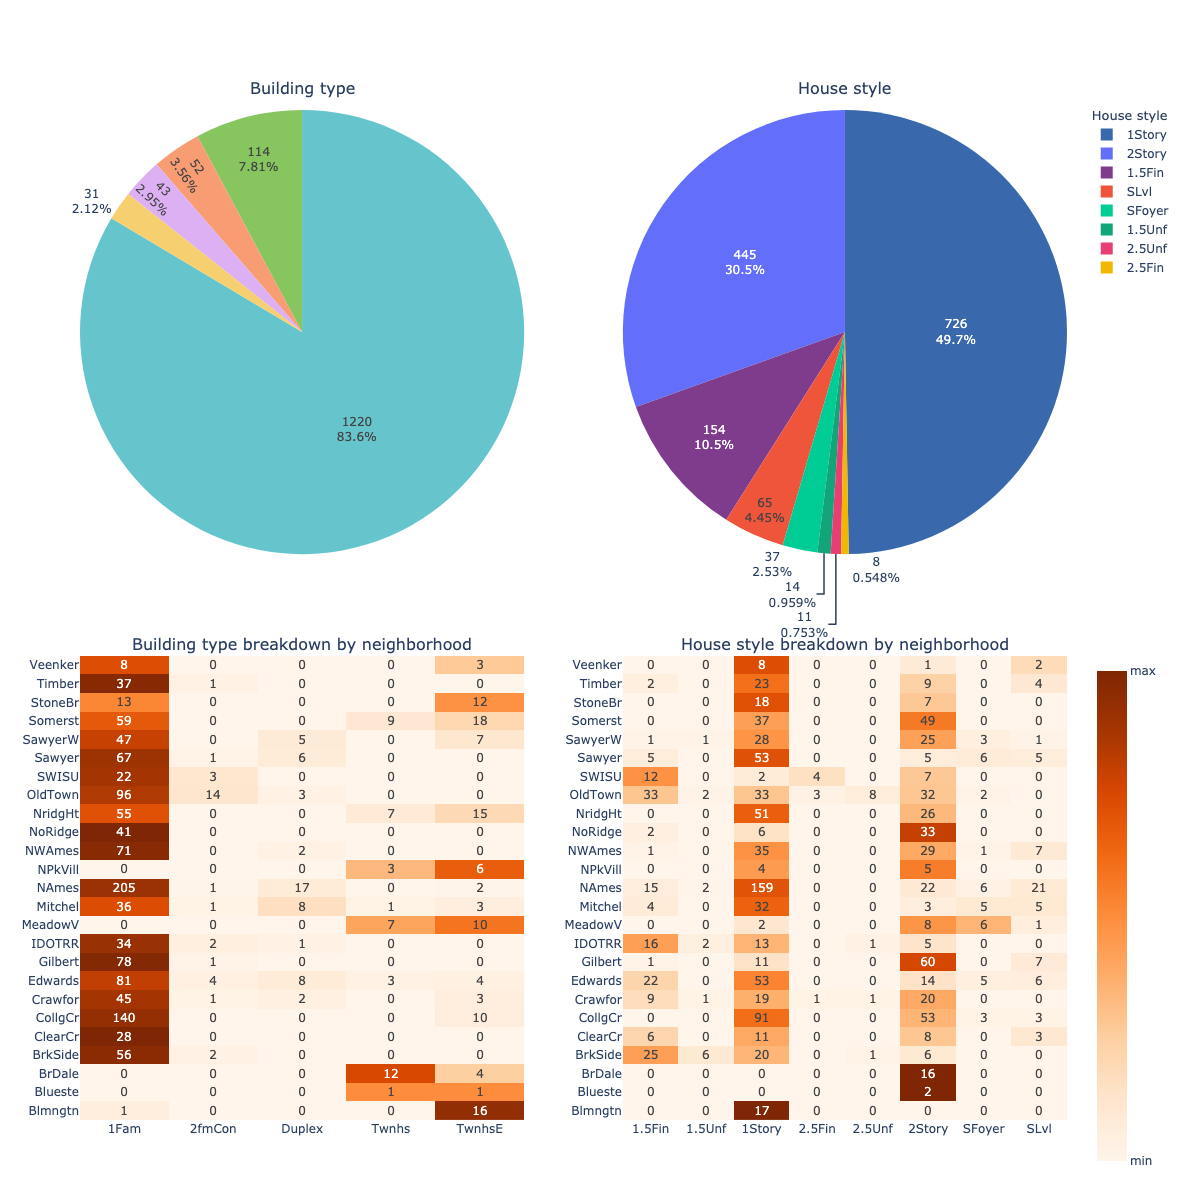

In [21]:
fig_eda_3 = make_subplots(rows=2, cols=2, vertical_spacing=0.09,
                    specs=[[{"type":"domain"}, {"type":"domain"}], [{"type":"xy"}, {"type":"xy"}]],
                    subplot_titles=["Building type", "House style", 
                                    "Building type breakdown by neighborhood", "House style breakdown by neighborhood"])

fig_eda_3.add_trace( go.Pie(values=house_bldg_type_1["count"], labels=house_bldg_type_1["bldg_type"],
                      textinfo="value+percent", 
                      marker=dict(colors=px.colors.qualitative.Pastel[0:len(house_bldg_type_1["bldg_type"])]),
                      legend="legend1", legendgroup="1", legendgrouptitle=dict(text="Building type")),
              row=1, col=1)

fig_eda_3.add_trace( go.Pie(values=house_style_1["count"], labels=house_style_1["house_style"], 
                      textinfo="value+percent",
                      marker=dict(colors=px.colors.qualitative.Bold[0:len(house_bldg_type_1["bldg_type"])]),
                      legend="legend2", legendgroup="2", legendgrouptitle=dict(text="House style")),
              row=1, col=2)

fig_eda_3.add_trace(go.Heatmap(x=house_bldg_type_3.columns, y=house_bldg_type_3.index, 
                         z=house_bldg_type_3, text=house_bldg_type_2, texttemplate="%{text:,.0f}",
                         colorscale="Oranges", 
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"],
                                       len=0.5, y=0.2)
                         ),
            row=2, col=1)

fig_eda_3.add_trace(go.Heatmap(x=house_style_3.columns, y=house_style_3.index, 
                         z=house_style_3, text=house_style_2, texttemplate="%{text:,.0f}",
                         colorscale="Oranges",
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"], len=0.5),
                         showscale=False
                         ),
            row=2, col=2)

fig_eda_3.update_layout(height=1200, width=1200, hovermode=False,
                  )
fig_eda_3.show(renderer="png")

----
# <center> Feature Selection </center>
----

Split data into categorical and numerical data type.

In [22]:
##### split numerical and categorical data
num_cleaned_house_df = cleaned_house_df.select_dtypes(include=np.number)
cat_cleaned_house_df = cleaned_house_df.select_dtypes(exclude=np.number)

num_cleaned_house_df.head(5)

,ms_sub_class,lot_area,overall_qual,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_unf_sf,...,open_porch_sf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_price,age_sold
0,60,8450,7,5,2003,2003,196.0000,706,0,150,...,61,0,0,0,0,0,2,2008,208500,5
1,20,9600,6,8,1976,1976,0.0000,978,0,284,...,0,0,0,0,0,0,5,2007,181500,31
2,60,11250,7,5,2001,2002,162.0000,486,0,434,...,42,0,0,0,0,0,9,2008,223500,7
3,70,9550,7,5,1915,1970,0.0000,216,0,540,...,35,272,0,0,0,0,2,2006,140000,91
4,60,14260,8,5,2000,2000,350.0000,655,0,490,...,84,0,0,0,0,0,12,2008,250000,8


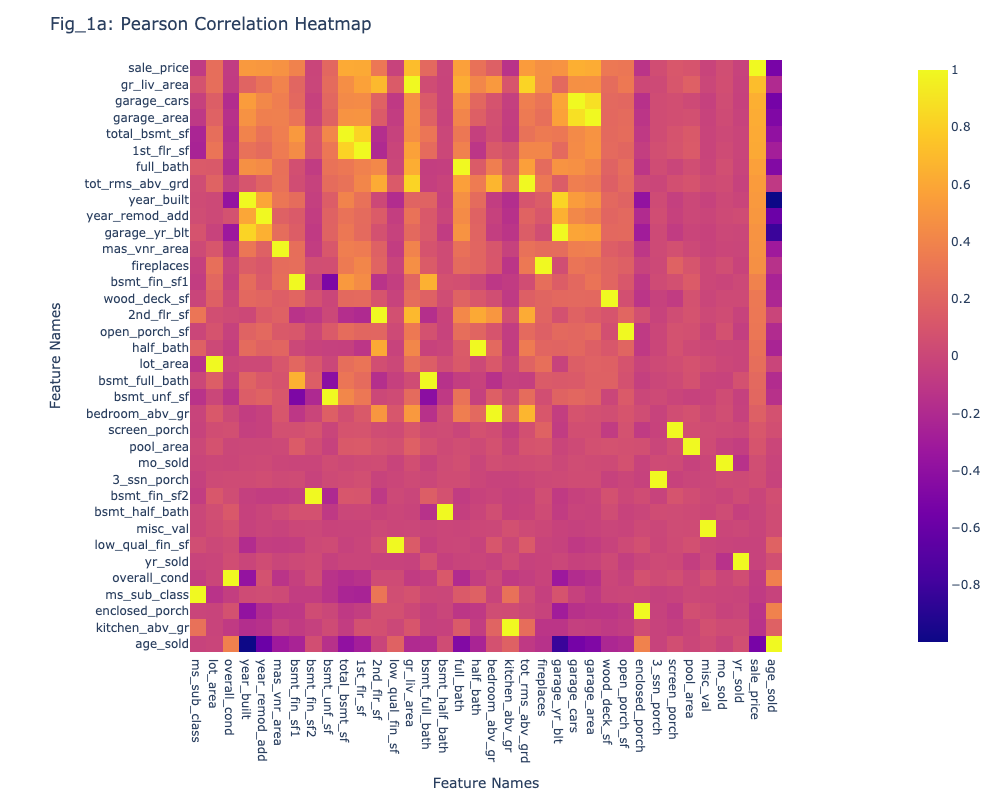

In [25]:
corr_matrix = num_cleaned_house_df.corr().sort_values("sale_price", ascending=False)
corr_matrix = corr_matrix.drop(columns=["overall_qual"]).drop(index=["overall_qual"])

fig_1a = px.imshow(corr_matrix)

fig_1a.update_xaxes(title_text="Feature Names")
fig_1a.update_yaxes(title_text="Feature Names")
fig_1a.update_layout(title_text="Fig_1a: Pearson Correlation Heatmap", height=800, width=1000)
fig_1a.show(renderer="png")

Fig_1a shows the heatmap of Pearson correlation matrix for features with numerical data type. The correlation compares two features at a time, and the correlation values can range from -1 to 1. When two features are negatively correlated, an increase in one feature decreases the other feature. On the other hand, when two features are positively correlated, an increase in one feature increases the other feature. A 0 correlation value means that the two features are not correlated, hence any increase or decrease in one feature does not affect the other feature.

The right most column of the heatmap shows how sale price is correlated to other feature. These values are extracted and plotted in Fig_1b.

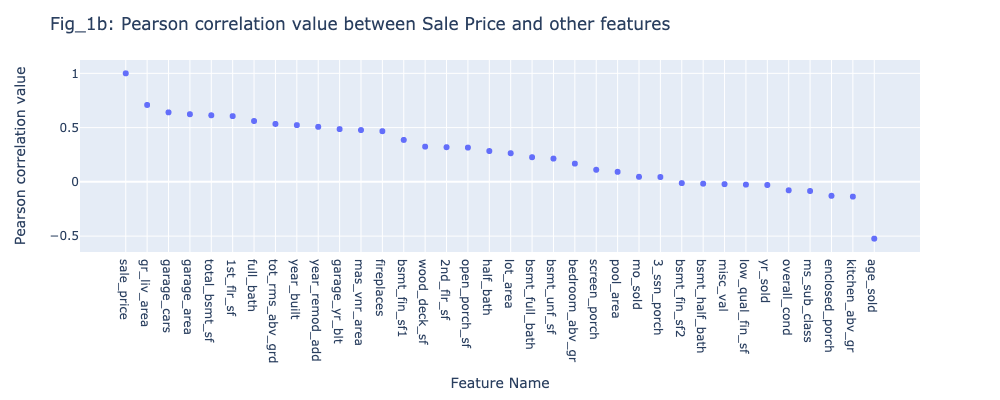

In [29]:
fig_1b = px.scatter(x=corr_matrix.index, y=corr_matrix["sale_price"])

fig_1b.update_xaxes(title_text="Feature Name")
fig_1b.update_yaxes(title_text="Pearson correlation value")
fig_1b.update_layout(title_text="Fig_1b: Pearson correlation value between Sale Price and other features", height=400, width=1000)
fig_1b.show(renderer="png")

Based on Fig_1b, some of the features that can be used to create a model are `gr_liv_area`, `garage_cars`, `garage_area`, `total_bsmt_sf`, and `1st_flr_sf`. The remainder features will not be included to avoid creating a complex model and potentially overfitting the model.

Additionally, `year_built`, `yr_sold`, `year_remod_add`, and `mo_sold` features were also included for feature engineering.



---
# <center> Model Development </center>
---

In [30]:
y = house_df["sale_price"]

num_cols = ["gr_liv_area", "garage_area", "total_bsmt_sf", "1st_flr_sf", "year_built", 
            "yr_sold", "year_remod_add", "mo_sold", "age_sold"]
cat_cols = ["neighborhood"]

num_X = num_cleaned_house_df[num_cols]
cat_X = cleaned_house_df[cat_cols]


##### Feature engineering
# num_X["house_age"] = num_X["yr_sold"] - num_X["year_built"]
# num_X.loc[num_X["house_age"]==0, "house_age"] = num_X.loc[num_X["house_age"]==0, "mo_sold"]/12
num_X.loc[num_X["age_sold"]==0, "age_sold"] = num_X.loc[num_X["age_sold"]==0, "mo_sold"]/12
num_X["scaled_remod"] = (num_X["year_remod_add"] - num_X["year_built"])/num_X["age_sold"]


##### Drop unnecessary columns
num_X = num_X.drop(columns=["year_built", "yr_sold", "mo_sold"])

X = num_X

##### Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)


##### create standard scaler
std_scaler = StandardScaler()
std_scaler.fit(X_train)

# ##### create one-hot encoder
# ohe_encoder = OneHotEncoder(sparse_output=False)
# ohe_encoder.fit(cat_X)


##### transform values using standard scaler
scaled_num_X_train = std_scaler.transform(X_train.select_dtypes(include=np.number))
scaled_num_X_test = std_scaler.transform(X_test.select_dtypes(include=np.number))


##### recreate dataframe after scaling and encoding
scaled_X_train_df = pd.DataFrame(data=scaled_num_X_train, columns=std_scaler.feature_names_in_)
scaled_X_test_df = pd.DataFrame(data=scaled_num_X_test, columns=std_scaler.feature_names_in_)

X_train = scaled_X_train_df
X_test = scaled_X_test_df




New features were generated using feature engineering. The new features include `age_sold` and `scaled_remod`. `age_sold` is the age of the house in years since it was built. This value was computed as `yr_sold` - `year_built`. If the house was sold in the same year it was built, then the month the house was sold will be divided by 12 to convert the house age to year. `scaled_remod` is the time when the house was remodeled scaled to its age. This value was computed as (`year_remod_add` - `year_built`)/`age_sold`.

After some experimentation, `garage_cars` feature were dropped since it did not improve the model accuracy. The categorical data were also found to not significantly improve the model accuracy.

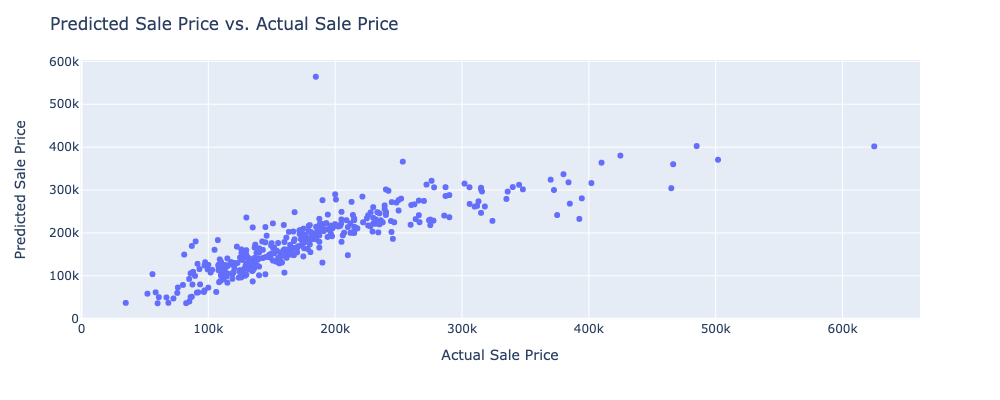

Test set score: 0.7276759228544866


In [32]:
##### Linear Regression model

lr_mod = LinearRegression()

lr_mod.fit(X_train, y_train)

fig_2a = px.scatter(x=y_test, y=lr_mod.predict(X_test))

fig_2a.update_xaxes(title_text="Actual Sale Price")
fig_2a.update_yaxes(title_text="Predicted Sale Price")
fig_2a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_2a.show(renderer="png")


print(f"Test set score: {lr_mod.score(X_test, y_test)}")


In [33]:
##### Random forest regressor
rfr_mdl = RandomForestRegressor(min_samples_split=0.2, 
                                max_samples=0.75,
                                n_estimators=200,
                                ccp_alpha=1000)

rfr_dist = dict(min_samples_split = uniform().rvs(size=1000),
                max_samples = uniform().rvs(size=1000),
                n_estimators = randint(high=1500, low=50).rvs(size=300),
                ccp_alpha = randint(high=100000, low=1).rvs(size=1000))

rscv_rfr = RandomizedSearchCV(rfr_mdl, rfr_dist, random_state=43, n_iter=50, verbose=3, cv=10)
search_rfr = rscv_rfr.fit(scaled_X_train_df, y_train)

best_params_rfr = search_rfr.best_params_
search_rfr.best_score_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.779 total time=   1.2s
[CV 2/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.786 total time=   1.2s
[CV 3/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.728 total time=   1.2s
[CV 4/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.690 total time=   1.2s
[CV 5/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.661 total time=   1.2s
[CV 6/10] END ccp_alpha=64760, max_samples=0.7525004663579722, min_samples_split=0.07757423846843647, n_estimators=1069;, score=0.589 total time=   1.2s
[CV 7/10] END ccp_a

0.7683358457762354

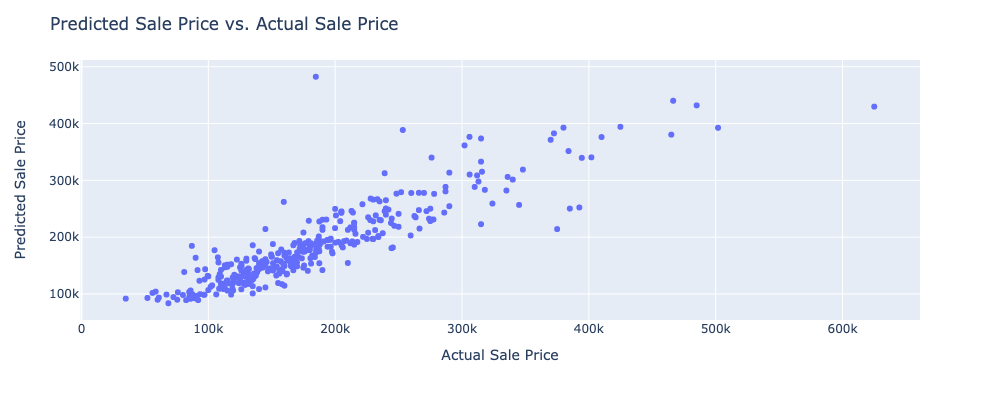

Test set score: 0.7966615378283713


In [35]:

final_rfr_mdl = RandomForestRegressor(min_samples_split=best_params_rfr["min_samples_split"], 
                                      max_samples=best_params_rfr["max_samples"],
                                      n_estimators=best_params_rfr["n_estimators"],
                                      ccp_alpha=best_params_rfr["ccp_alpha"])
final_rfr_mdl.fit(X_train, y_train)

fig_5a = px.scatter(x=y_test, y=final_rfr_mdl.predict(X_test))

fig_5a.update_xaxes(title_text="Actual Sale Price")
fig_5a.update_yaxes(title_text="Predicted Sale Price")
fig_5a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price", height=400, width=1000)
fig_5a.show(renderer="png")

print(f"Test set score: {final_rfr_mdl.score(X_test, y_test)}")

In [36]:
##### Gradient Boosting Regressor
gbr_mdl = GradientBoostingRegressor(n_estimators= 500,
                                    max_depth= 10,
                                    min_samples_split= 10,
                                    learning_rate = 0.2,
                                    loss = "squared_error",
                                    ccp_alpha = 100)


gbr_dist = dict(n_estimators = randint(high=1500, low=50).rvs(size=300),
                max_depth = randint(high=1500, low=3).rvs(size=300),
                min_samples_split = uniform().rvs(size=1000),
                learning_rate = uniform().rvs(size=1000),
                ccp_alpha = randint(high=100000, low=1).rvs(size=1000))

rscv_gbr = RandomizedSearchCV(gbr_mdl, gbr_dist, random_state=43, n_iter=30, verbose=3, cv=10)
search_gbr = rscv_gbr.fit(scaled_X_train_df, y_train)

best_params_gbr = search_gbr.best_params_
search_gbr.best_score_


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 1/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.69019215810944, n_estimators=203;, score=0.831 total time=   0.3s
[CV 2/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.69019215810944, n_estimators=203;, score=0.828 total time=   0.2s
[CV 3/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.69019215810944, n_estimators=203;, score=0.823 total time=   0.2s
[CV 4/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.69019215810944, n_estimators=203;, score=0.601 total time=   0.3s
[CV 5/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.69019215810944, n_estimators=203;, score=0.842 total time=   0.2s
[CV 6/10] END ccp_alpha=50037, learning_rate=0.9782168610170003, max_depth=700, min_samples_split=0.6901921

0.7539017947811948

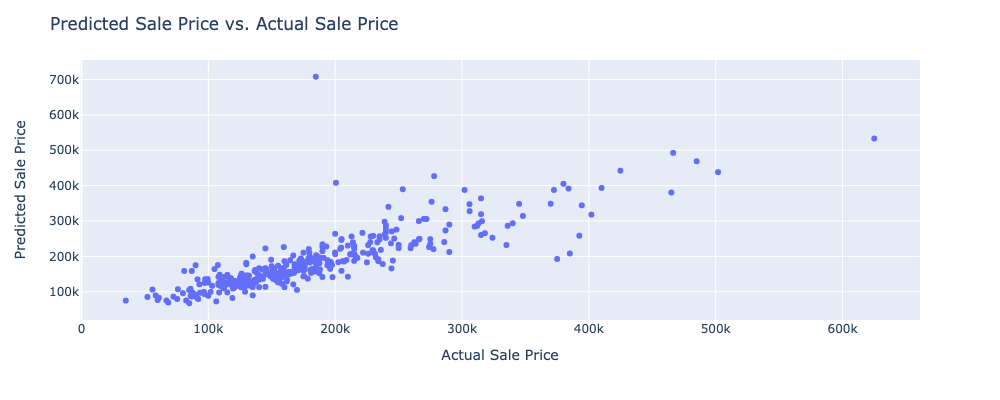

Testing score: 0.6867985709172054


In [37]:
final_gbr_mdl = GradientBoostingRegressor(n_estimators= best_params_gbr["n_estimators"],
                                          max_depth= best_params_gbr["max_depth"],
                                          min_samples_split= best_params_gbr["min_samples_split"],
                                          learning_rate = best_params_gbr["learning_rate"], 
                                          loss = "squared_error",
                                          ccp_alpha = best_params_gbr["ccp_alpha"])
final_gbr_mdl.fit(scaled_X_train_df, y_train)

fig_6a = px.scatter(x=y_test, y=final_gbr_mdl.predict(X_test))

fig_6a.update_xaxes(title_text="Actual Sale Price")
fig_6a.update_yaxes(title_text="Predicted Sale Price")
fig_6a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_6a.show(renderer="png")


print(f"Testing score: {final_gbr_mdl.score(scaled_X_test_df, y_test)}")

3 models were used for prediction: linear regression, random forest regression, and gradient boosting regression. The score for each model is 0.7276, 0.7967, and 0.6868, respectively. Based on this, random forest regression perform the best among the 3 models. Thus, random forest model was used to make prediction for the testing set.

----
# <center>Testing Set </center>
----

The following testing set was obtained as part of the House Prices -- Advance Regression Techniques competition on Kaggle. Random Forest Regression was selected to be used to predict the house prices based on the selected features. The predicted house price was then submitted to Kaggle for evaluation.

In [38]:
house_testing_set = pd.read_csv("house_price_test.csv")
house_testing_set.columns = [infl.underscore(val) for val in house_testing_set.columns]

id_col = house_testing_set["id"]

coi_testing = ["gr_liv_area", "garage_area", "total_bsmt_sf", "1st_flr_sf", "year_built", 
                "yr_sold", "year_remod_add", "mo_sold"]

house_testing_set = house_testing_set[coi_testing]

##### Feature engineering
house_testing_set["age_sold"] = house_testing_set["yr_sold"] - house_testing_set["year_built"]
house_testing_set.loc[house_testing_set["age_sold"]==0, "age_sold"] = house_testing_set.loc[house_testing_set["age_sold"]==0, "mo_sold"]/12
house_testing_set["scaled_remod"] = (house_testing_set["year_remod_add"] - house_testing_set["year_built"])/house_testing_set["age_sold"]

##### Drop unnecessary columns
house_testing_set = house_testing_set.drop(columns=["year_built", "yr_sold", "mo_sold"])

##### fillna
house_testing_set = house_testing_set.fillna(0)

##### transform values
scaled_testing_set = std_scaler.transform(house_testing_set)

##### recreate dataframe after scaling and encoding
house_testing_set = pd.DataFrame(data=scaled_testing_set, columns=std_scaler.feature_names_in_)

house_testing_set

,gr_liv_area,garage_area,total_bsmt_sf,1st_flr_sf,year_remod_add,age_sold,scaled_remod
0,-1.2010,1.2563,-0.3908,-0.6923,-1.1573,0.4007,-0.7201
1,-0.3585,-0.7472,0.6241,0.4418,-1.3028,0.4997,-0.7201
2,0.2253,0.0676,-0.2864,-0.6085,0.6373,-0.7871,-0.5076
3,0.1766,0.0101,-0.2909,-0.6137,0.6373,-0.8201,-0.7201
4,-0.4538,0.1827,0.5128,0.3135,0.3462,-0.6221,-0.7201
...,...,...,...,...,...,...,...
1454,-0.8196,-2.2426,-1.1536,-1.6090,-0.7208,-0.0282,-0.7201
1455,-0.8196,-0.8718,-1.1536,-1.6090,-0.7208,-0.0282,-0.7201
1456,-0.5628,0.5182,0.3857,0.1668,0.5403,0.3017,1.4421
1457,-1.0570,-2.2426,-0.3227,-0.4985,0.3462,-0.7541,-0.7201


In [75]:
prediction = final_rfr_mdl.predict(house_testing_set)

submission = pd.DataFrame(list(zip(id_col, prediction)), columns=["Id", "SalePrice"])
submission.to_csv("submission_house.csv", index=False)

The submission_house.csv was submitted to the page on Kaggle to receive the final score.

----
# <center>Regression Analysis </center>
----

This part is used to investigate the performance of the model built above.

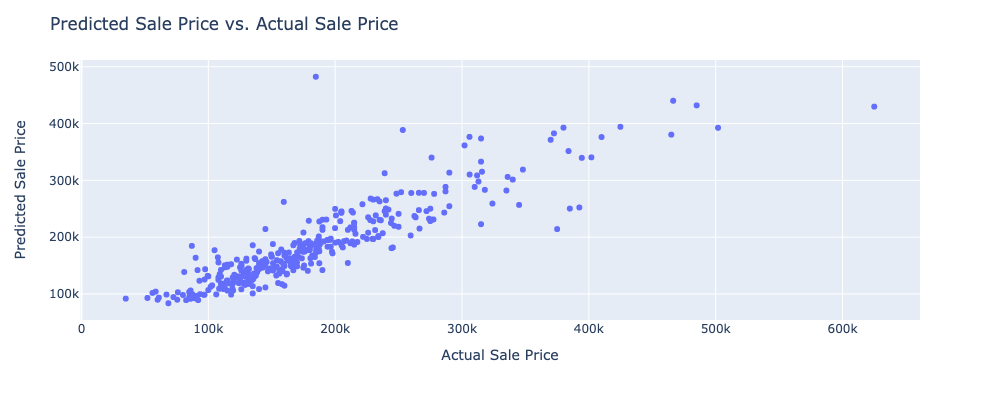

Test set score: 0.7966615378283713


In [39]:
fig_2a = px.scatter(x=y_test, y=final_rfr_mdl.predict(scaled_X_test_df))

fig_2a.update_xaxes(title_text="Actual Sale Price")
fig_2a.update_yaxes(title_text="Predicted Sale Price")
fig_2a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_2a.show(renderer="png")


print(f"Test set score: {final_rfr_mdl.score(scaled_X_test_df, y_test)}")

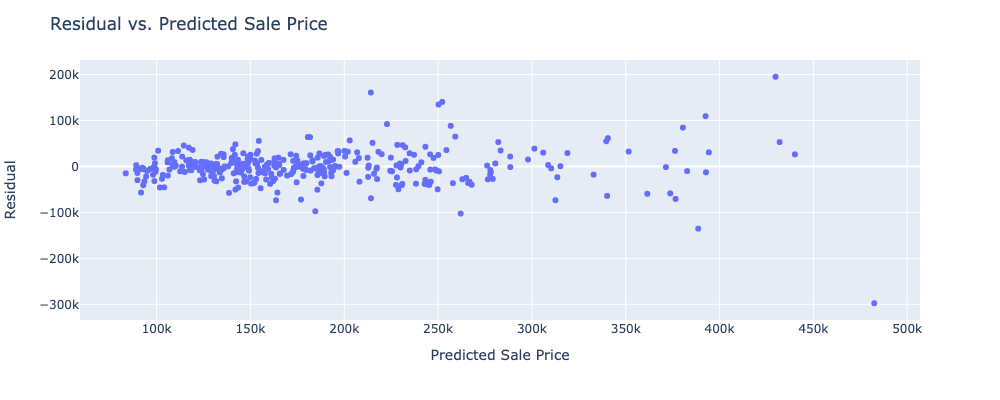

In [40]:
rfr_predicted_y = final_rfr_mdl.predict(scaled_X_test_df)
rfr_residual = y_test - rfr_predicted_y
rfr_z_score = (rfr_residual - np.mean(rfr_residual))/np.std(rfr_residual)

fig_2b = px.scatter(x=rfr_predicted_y, y=rfr_residual)

fig_2b.update_xaxes(title_text="Predicted Sale Price")
fig_2b.update_yaxes(title_text="Residual")
fig_2b.update_layout(title_text="Residual vs. Predicted Sale Price",  height=400, width=1000)
fig_2b.show(renderer="png")

Based on residual vs. predicted sale price, it can be seen that the random forest model performed relatively good at the lower end of the house price. As the house price increases, the model performance deteriorate. In order to enhance the model ability to make better prediction, something has to be done for house with higher price.

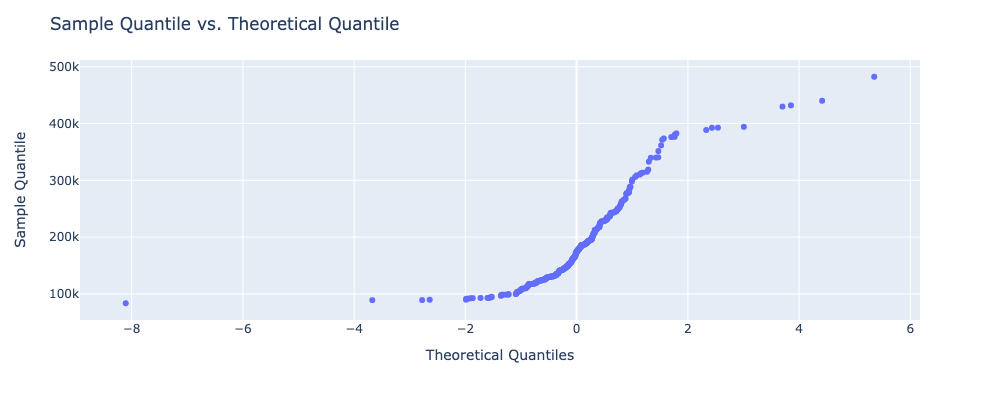

In [41]:
fig_2c = px.scatter(x=sorted(rfr_z_score), y=sorted(rfr_predicted_y))

fig_2c.update_xaxes(title_text="Theoretical Quantiles")
fig_2c.update_yaxes(title_text="Sample Quantile")
fig_2c.update_layout(title_text="Sample Quantile vs. Theoretical Quantile",  height=400, width=1000)
fig_2c.show(renderer="png")